In [1]:
import copy
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod


def calc_total_head_movement(seq: list) -> int:
    total_head_movement = 0
    for i in range(1, len(seq)):
        total_head_movement += abs(seq[i] - seq[i - 1])
    return total_head_movement


def calc_mean_waiting_time(seq: list, times: list, service_time: int = 0) -> float:
    total_waiting_time = 0
    for i in range(0, len(seq) - 1):
        total_waiting_time += calc_total_head_movement(seq[:i + 2]) - times[i] + (service_time if i > 0 else 0)
    return total_waiting_time / (len(seq) - 1)


def calc_waiting_times(seq: list, times: list, max_cyl: int, cyls_per_ms: int = 1, service_time: int = 0) -> list[tuple[int, float]]:
    waiting_times = []
    j = 0
    for i in range(0, len(seq) - 1):
        if seq[i + 1] == 0 or seq[i + 1] == max_cyl:
            continue

        waiting_times.append((seq[i + 1], (calc_total_head_movement(seq[:i + 2]) - times[j]) / cyls_per_ms + (service_time if j > 0 else 0)))
        j += 1
    return waiting_times

def calc_cum_seek_time(seq: list, service_time: int = 0) -> list[tuple[int, float]]:
    cum_seek_time = []
    for i in range(0, len(seq) - 1):
        cum_seek_time.append((seq[i + 1], calc_total_head_movement(seq[:i + 2]) + (service_time if i > 0 else 0)))
    return cum_seek_time


class DiskSchedulingAlgorithm(ABC):
    def __init__(self, init_head_pos: int, max_cyl: int):
        self.init_head_pos = init_head_pos
        self.max_cyl = max_cyl

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def process_sequence(self, seq: list) -> list:
        pass


class FCFS(DiskSchedulingAlgorithm):
    def __init__(self, init_head_pos: int, max_cyl: int):
        super().__init__(init_head_pos, max_cyl)

    def __str__(self):
        return 'FCFS'

    def process_sequence(self, seq: list, times: list = None) -> list:
        working_seq = copy.deepcopy(seq)
        working_times = copy.deepcopy(times) if times is not None else None
        current_head_position = self.init_head_pos
        processed_seq = [current_head_position]
        time = 0
        while len(working_seq) > 0:
            if working_times is not None:
                available_cylinders = [cylinder for cylinder, t in zip(working_seq, working_times) if t <= time]
            else:
                available_cylinders = working_seq

            processed_seq.append(available_cylinders[0])
            if working_times is not None:
                working_times.remove(working_times[working_seq.index(available_cylinders[0])])
            working_seq.remove(available_cylinders[0])
            time += calc_total_head_movement(processed_seq[-2:])

        return processed_seq


class SSTF(DiskSchedulingAlgorithm):
    def __init__(self, init_head_pos: int, max_cyl: int):
        super().__init__(init_head_pos, max_cyl)

    def __str__(self):
        return 'SSTF'

    def process_sequence(self, seq: list, times: list = None) -> list:
        working_seq = copy.deepcopy(seq)
        working_times = copy.deepcopy(times) if times is not None else None
        current_head_position = self.init_head_pos
        processed_seq = [current_head_position]
        time = 0
        while len(working_seq) > 0:
            if working_times is not None:
                available_cylinders = [cylinder for cylinder, t in zip(working_seq, working_times) if t <= time]
            else:
                available_cylinders = working_seq

            closest_cylinder = min(available_cylinders, key=lambda x: abs(x - current_head_position))
            current_head_position = closest_cylinder
            processed_seq.append(current_head_position)
            if working_times is not None:
                working_times.remove(working_times[working_seq.index(closest_cylinder)])
            working_seq.remove(closest_cylinder)
            time += calc_total_head_movement(processed_seq[-2:])

        return processed_seq


class SCAN(DiskSchedulingAlgorithm):
    def __init__(self, init_head_pos: int, max_cyl: int, direction: str):
        super().__init__(init_head_pos, max_cyl)
        self.direction = direction

    def __str__(self):
        return f'SCAN ({self.direction})'

    def process_sequence(self, seq: list, times: list = None) -> list:
        working_seq = copy.deepcopy(seq)
        working_times = copy.deepcopy(times) if times is not None else None
        current_head_position = self.init_head_pos
        processed_seq = [current_head_position]
        time = 0
        while len(working_seq) > 0:
            if working_times is not None:
                available_cylinders = [cylinder for cylinder, t in zip(working_seq, working_times) if t <= time]
            else:
                available_cylinders = working_seq
            if self.direction == 'left':
                available_cylinders = [cylinder for cylinder in available_cylinders if cylinder <= current_head_position]
                if len(available_cylinders) == 0:
                    if current_head_position != 0:
                        processed_seq.append(0)
                    self.direction = 'right'
                    time += calc_total_head_movement(processed_seq[-2:])
                    continue
            elif self.direction == 'right':
                available_cylinders = [cylinder for cylinder in available_cylinders if cylinder >= current_head_position]
                if len(available_cylinders) == 0:
                    if current_head_position != self.max_cyl:
                        processed_seq.append(self.max_cyl)
                    self.direction = 'left'
                    time += calc_total_head_movement(processed_seq[-2:])
                    continue
            else:
                raise ValueError(f'Invalid direction: {self.direction}')

            closest_cylinder = min(available_cylinders, key=lambda x: abs(x - current_head_position))
            current_head_position = closest_cylinder
            processed_seq.append(current_head_position)
            if working_times is not None:
                working_times.remove(working_times[working_seq.index(closest_cylinder)])
            working_seq.remove(closest_cylinder)
            time += calc_total_head_movement(processed_seq[-2:])

        return processed_seq


class C_SCAN(DiskSchedulingAlgorithm):
    def __init__(self, init_head_pos: int, max_cyl: int, direction: str):
        super().__init__(init_head_pos, max_cyl)
        self.direction = direction

    def __str__(self):
        return f'C-SCAN ({self.direction})'

    def process_sequence(self, seq: list) -> list:
        working_seq = copy.deepcopy(seq)
        curr_head_pos = self.init_head_pos
        processed_seq = [curr_head_pos]
        while len(working_seq) > 0:
            if self.direction == 'left':
                available_cylinders = [cylinder for cylinder in working_seq if cylinder <= curr_head_pos]
                if len(available_cylinders) == 0:
                    processed_seq.append(0)
                    processed_seq.append(self.max_cyl)
                    curr_head_pos = self.max_cyl
                    continue
            elif self.direction == 'right':
                available_cylinders = [cylinder for cylinder in working_seq if cylinder >= curr_head_pos]
                if len(available_cylinders) == 0:
                    processed_seq.append(self.max_cyl)
                    processed_seq.append(0)
                    curr_head_pos = 0
                    continue
            else:
                raise ValueError(f'Invalid direction: {self.direction}')

            closest_cylinder = min(available_cylinders, key=lambda x: abs(x - curr_head_pos))
            curr_head_pos = closest_cylinder
            processed_seq.append(curr_head_pos)
            working_seq.remove(closest_cylinder)

        return processed_seq


class LOOK(DiskSchedulingAlgorithm):
    def __init__(self, init_head_pos: int, max_cyl: int, direction: str):
        super().__init__(init_head_pos, max_cyl)
        self.direction = direction

    def __str__(self):
        return f'LOOK ({self.direction})'

    def process_sequence(self, seq: list, times: list = None) -> list:
        working_seq = copy.deepcopy(seq)
        working_times = copy.deepcopy(times) if times is not None else None
        current_head_position = self.init_head_pos
        processed_seq = [current_head_position]
        time = 0
        while len(working_seq) > 0:
            if working_times is not None:
                available_cylinders = [cylinder for cylinder, t in zip(working_seq, working_times) if t <= time]
            else:
                available_cylinders = working_seq
            if self.direction == 'left':
                available_cylinders = [cylinder for cylinder in available_cylinders if cylinder <= current_head_position]
                if len(available_cylinders) == 0:
                    self.direction = 'right'
                    continue
            elif self.direction == 'right':
                available_cylinders = [cylinder for cylinder in available_cylinders if cylinder >= current_head_position]
                if len(available_cylinders) == 0:
                    self.direction = 'left'
                    continue
            else:
                raise ValueError(f'Invalid direction: {self.direction}')

            closest_cylinder = min(available_cylinders, key=lambda x: abs(x - current_head_position))
            current_head_position = closest_cylinder
            processed_seq.append(current_head_position)
            if working_times is not None:
                working_times.remove(working_times[working_seq.index(closest_cylinder)])
            working_seq.remove(closest_cylinder)
            time += calc_total_head_movement(processed_seq[-2:])

        return processed_seq


class C_LOOK(DiskSchedulingAlgorithm):
    def __init__(self, init_head_pos: int, max_cyl: int, direction: str):
        super().__init__(init_head_pos, max_cyl)
        self.direction = direction

    def __str__(self):
        return f'C-LOOK ({self.direction})'

    def process_sequence(self, seq: list, times: list = None) -> list:
        working_seq = copy.deepcopy(seq)
        working_times = copy.deepcopy(times) if times is not None else None
        curr_head_pos = self.init_head_pos
        processed_seq = [curr_head_pos]
        time = 0
        while len(working_seq) > 0:
            if working_times is not None:
                available_cylinders = [cylinder for cylinder, t in zip(working_seq, working_times) if t <= time]
            else:
                available_cylinders = working_seq

            if self.direction == 'left':
                direction_cylinders = [cylinder for cylinder in available_cylinders if cylinder <= curr_head_pos]
                if len(direction_cylinders) == 0:
                    next_cylinder = max(available_cylinders)
                    processed_seq.append(next_cylinder)
                    curr_head_pos = next_cylinder
                    if working_times is not None:
                        working_times.remove(working_times[working_seq.index(next_cylinder)])
                    working_seq.remove(next_cylinder)
                    time += calc_total_head_movement(processed_seq[-2:])
                    continue
            elif self.direction == 'right':
                direction_cylinders = [cylinder for cylinder in available_cylinders if cylinder >= curr_head_pos]
                if len(direction_cylinders) == 0:
                    next_cylinder = min(available_cylinders)
                    processed_seq.append(next_cylinder)
                    curr_head_pos = next_cylinder
                    if working_times is not None:
                        working_times.remove(working_times[working_seq.index(next_cylinder)])
                    working_seq.remove(next_cylinder)
                    time += calc_total_head_movement(processed_seq[-2:])
                    continue
            else:
                raise ValueError(f'Invalid direction: {self.direction}')

            closest_cylinder = min(direction_cylinders, key=lambda x: abs(x - curr_head_pos))
            curr_head_pos = closest_cylinder
            processed_seq.append(curr_head_pos)
            if working_times is not None:
                working_times.remove(working_times[working_seq.index(closest_cylinder)])
            working_seq.remove(closest_cylinder)
            time += calc_total_head_movement(processed_seq[-2:])

        return processed_seq


def plot_sequence(seq: list, max_cyl: int, service_time: int = 0):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title('Disk Scheduling')
    ax.set_xlabel('Cylinder')
    ax.set_ylabel('Time')
    ax.set_ylim(-1, len(seq))
    ax.set_xlim(0, max_cyl)
    ax.set_yticks(range(len(seq)))
    ax.set_xticks(seq)
    ax.set_xticklabels(seq, rotation=90)
    cum_times = calc_cum_seek_time(seq, service_time)
    ax.set_yticklabels([0] + [cum_times[i][1] for i in range(len(cum_times))])
    ax.invert_yaxis()
    ax.grid(axis='x')

    ax.scatter(seq[0], 0, color='red', marker='x', s=100, label='Initial Head Position')
    ax.scatter(seq[1:-1], range(1, len(seq) - 1), color='black', marker='o', s=50, label='Intermediate Head Position')
    ax.scatter(seq[-1], len(seq) - 1, color='green', marker='x', s=100, label='Final Head Position')
    ax.plot(seq, range(len(seq)), color='blue', linewidth=2, label='Sequence')

    ax.legend()
    plt.show()


Slide

In [2]:
sequence = [98, 183, 37, 122, 14, 124, 65, 67]
max_cylinder = 199
initial_head_position = 53

FCFS

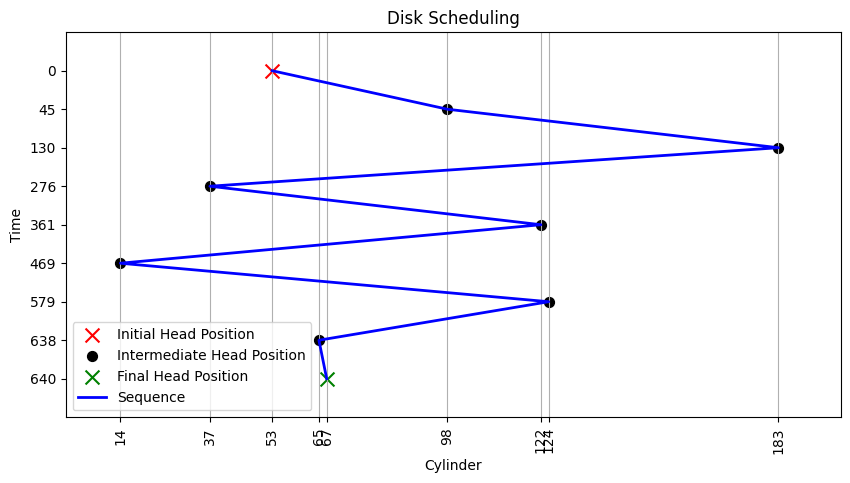

Total head movement: 640


In [3]:
fcfs_sequence = FCFS(initial_head_position, max_cylinder).process_sequence(sequence)

plot_sequence(fcfs_sequence, max_cylinder)

solution = [53, 98, 183, 37, 122, 14, 124, 65, 67]
assert fcfs_sequence == solution, f'{solution} expected, got {fcfs_sequence}'

fcfs_total_head_movement = calc_total_head_movement(fcfs_sequence)
print(f'Total head movement: {fcfs_total_head_movement}')
assert fcfs_total_head_movement == 640, f'640 expected, got {fcfs_total_head_movement}'

SSTF

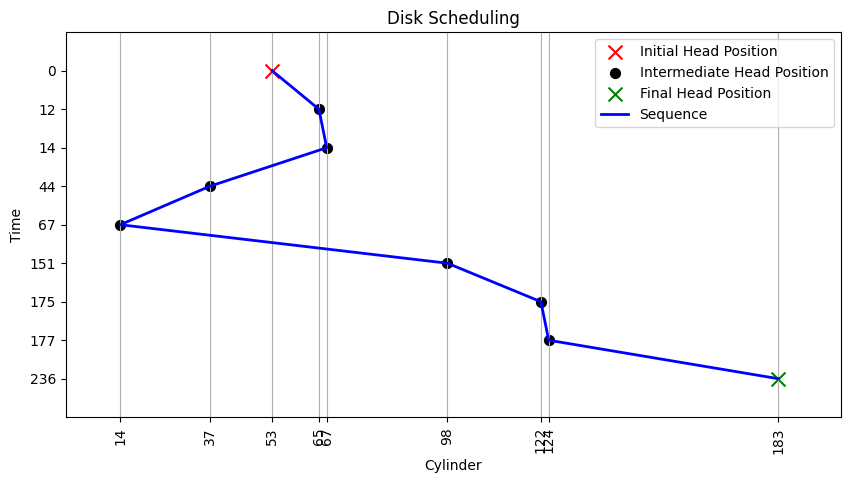

Total head movement: 236


In [4]:
sstf_sequence = SSTF(initial_head_position, max_cylinder).process_sequence(sequence)

plot_sequence(sstf_sequence, max_cylinder)

solution = [53, 65, 67, 37, 14, 98, 122, 124, 183]
assert sstf_sequence == solution, f'{solution} expected, got {sstf_sequence}'

sstf_total_head_movement = calc_total_head_movement(sstf_sequence)
print(f'Total head movement: {sstf_total_head_movement}')
assert sstf_total_head_movement == 236, f'236 expected, got {sstf_total_head_movement}'

SCAN left

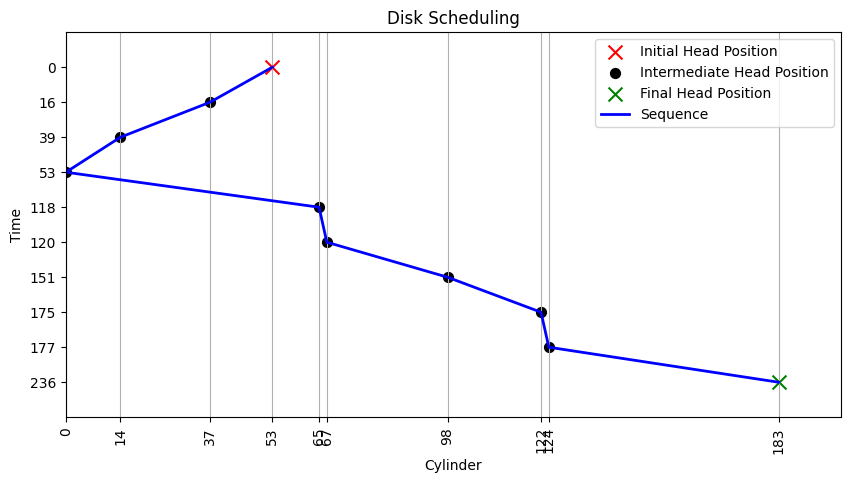

Total head movement: 236


In [5]:
scan_left_sequence = SCAN(initial_head_position, max_cylinder, 'left').process_sequence(sequence)

plot_sequence(scan_left_sequence, max_cylinder)

solution = [53, 37, 14, 0, 65, 67, 98, 122, 124, 183]
assert scan_left_sequence == solution, f'{solution} expected, got {scan_left_sequence}'

scan_left_total_head_movement = calc_total_head_movement(scan_left_sequence)
print(f'Total head movement: {scan_left_total_head_movement}')
assert scan_left_total_head_movement == 236, f'236 expected, got {scan_left_total_head_movement}'

C-SCAN right

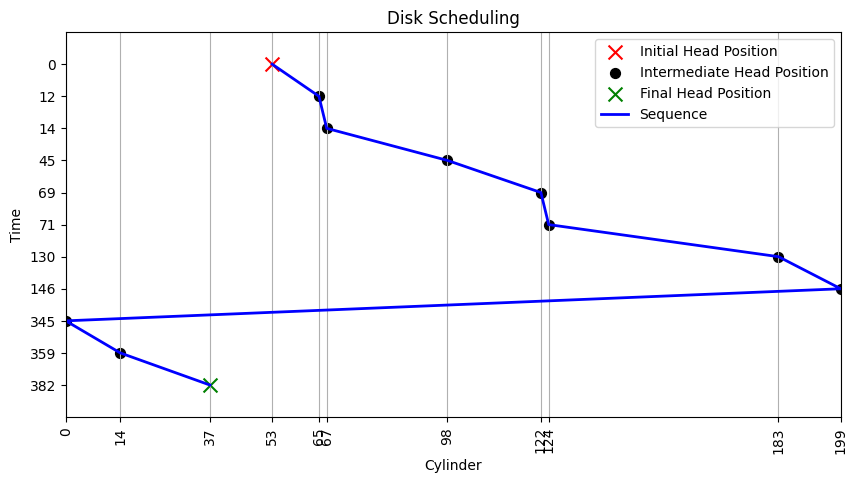

Total head movement: 382


In [6]:
c_scan_right_sequence = C_SCAN(initial_head_position, max_cylinder, 'right').process_sequence(sequence)

plot_sequence(c_scan_right_sequence, max_cylinder)

solution = [53, 65, 67, 98, 122, 124, 183, 199, 0, 14, 37]
assert c_scan_right_sequence == solution, f'{solution} expected, got {c_scan_right_sequence}'

c_scan_left_total_head_movement = calc_total_head_movement(c_scan_right_sequence)
print(f'Total head movement: {c_scan_left_total_head_movement}')
assert c_scan_left_total_head_movement == 382, f'382 expected, got {c_scan_left_total_head_movement}'

C-LOOK right

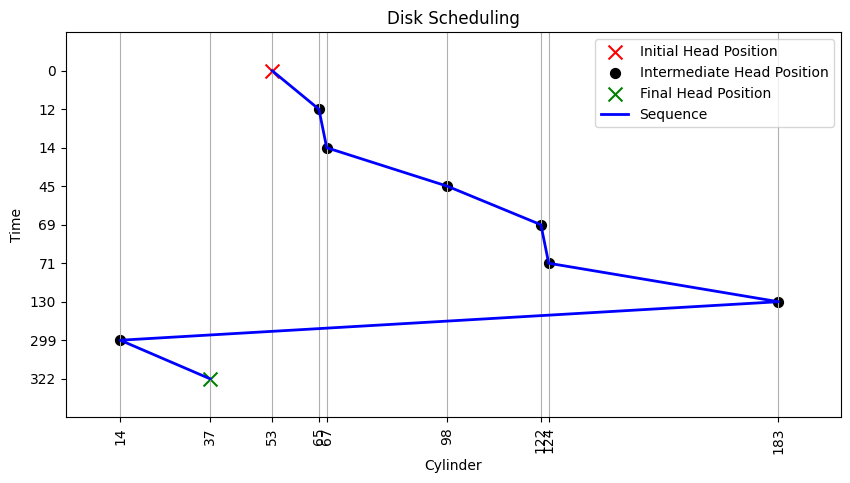

Total head movement: 322


In [7]:
c_look_right_sequence = C_LOOK(initial_head_position, max_cylinder, 'right').process_sequence(sequence)

plot_sequence(c_look_right_sequence, max_cylinder)

solution = [53, 65, 67, 98, 122, 124, 183, 14, 37]
assert c_look_right_sequence == solution, f'{solution} expected, got {c_look_right_sequence}'

c_look_right_total_head_movement = calc_total_head_movement(c_look_right_sequence)
print(f'Total head movement: {c_look_right_total_head_movement}')
assert c_look_right_total_head_movement == 322, f'322 expected, got {c_look_right_total_head_movement}'

E4)

In [8]:
sequence_cylinders = [77, 43, 30, 80]
sequence_times = [0, 20, 50, 55]
initial_head_position = 24
max_cylinder = 100
direction = 'right'

SSTF

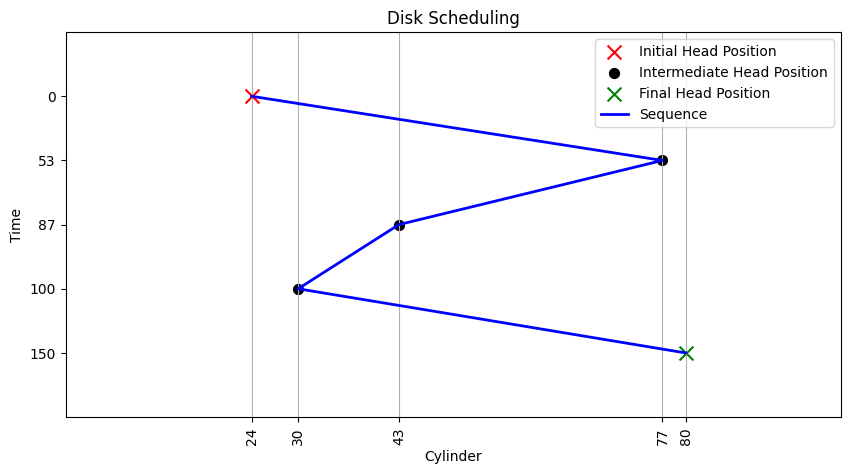

Total head movement: 150
Mean waiting time: 66.25


In [9]:
sstf_sequence = SSTF(initial_head_position, max_cylinder).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(sstf_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(sstf_sequence)}')
print(f'Mean waiting time: {calc_mean_waiting_time(sstf_sequence, sequence_times)}')

LOOK

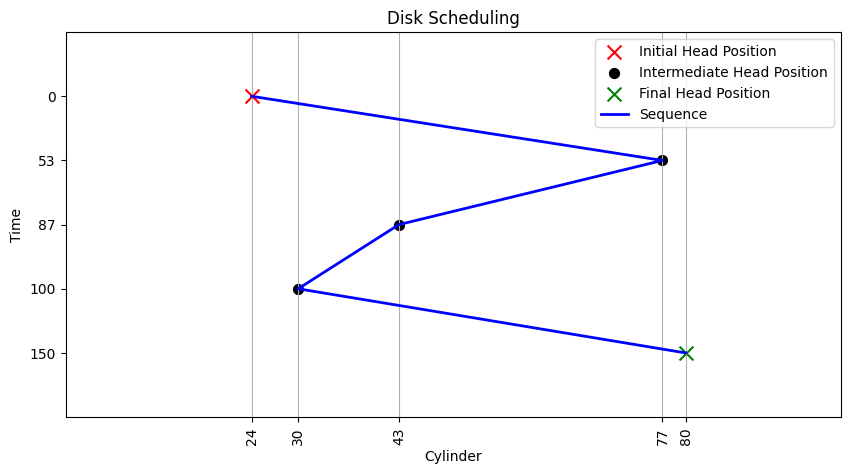

Total head movement: 150
Mean waiting time: 66.25


In [10]:
look_sequence = LOOK(initial_head_position, max_cylinder, direction).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(look_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(look_sequence)}')
print(f'Mean waiting time: {calc_mean_waiting_time(look_sequence, sequence_times)}')

E9)

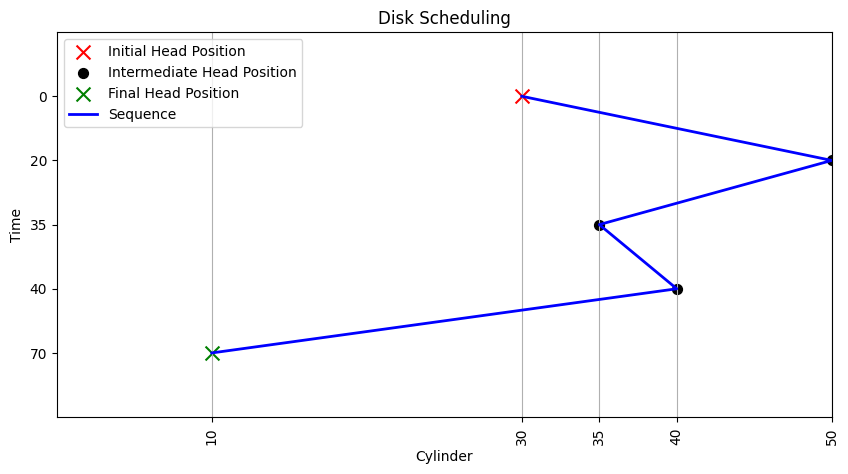

Total head movement: 70
Mean waiting time: 28.75


In [11]:
sequence_cylinders = [50, 35, 10, 40]
sequence_times = [0, 7, 10, 33]
initial_head_position = 30
max_cylinder = max(sequence_cylinders)

sstf_sequence = SSTF(initial_head_position, max_cylinder).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(sstf_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(sstf_sequence)}')
print(f'Mean waiting time: {calc_mean_waiting_time(sstf_sequence, sequence_times)}')

E13)

In [12]:
sequence = [143, 140, 37, 12, 95, 180, 57, 12]
max_cylinder = 199
initial_head_position = 100
direction = 'right'

SSTF

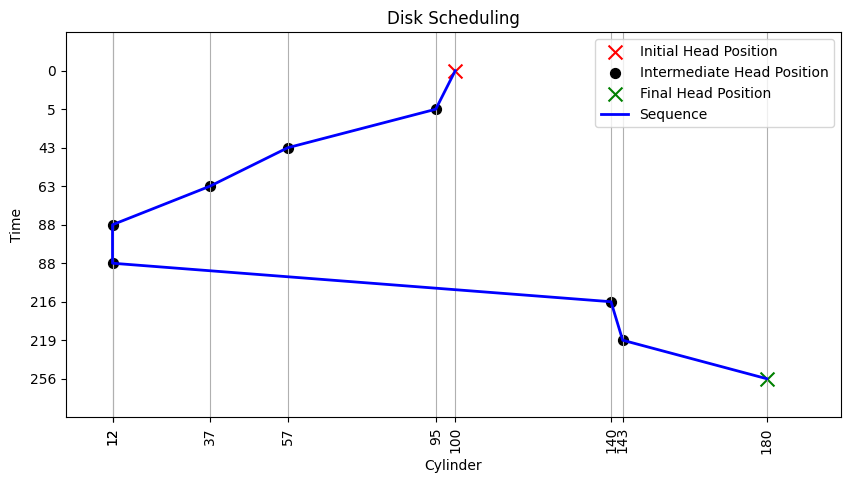

Total head movement: 256


In [13]:
sstf_sequence = SSTF(initial_head_position, max_cylinder).process_sequence(sequence)

plot_sequence(sstf_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(sstf_sequence)}')

SCAN

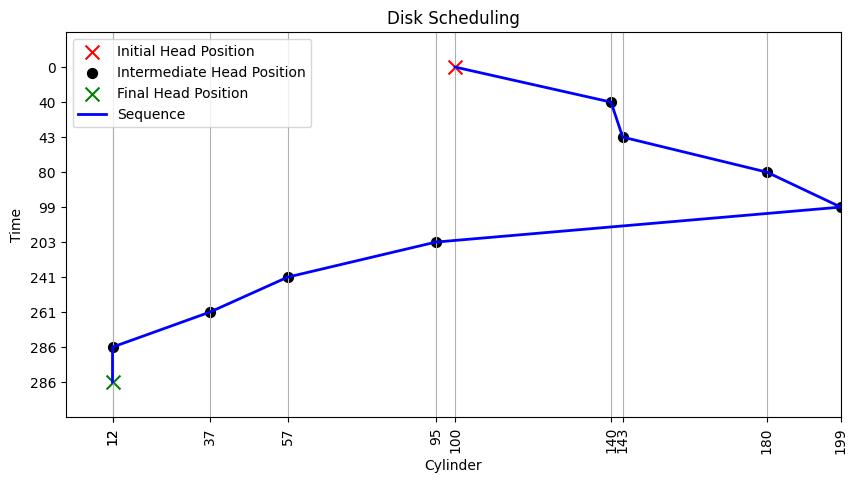

Total head movement: 286


In [14]:
scan_sequence = SCAN(initial_head_position, max_cylinder, direction).process_sequence(sequence)

plot_sequence(scan_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(scan_sequence)}')

C-SCAN

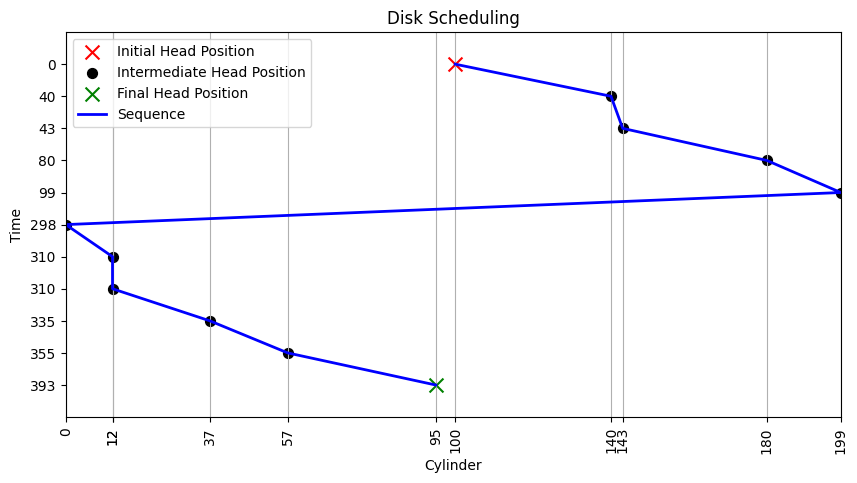

Total head movement: 393


In [15]:
c_scan_sequence = C_SCAN(initial_head_position, max_cylinder, direction).process_sequence(sequence)

plot_sequence(c_scan_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(c_scan_sequence)}')

E18)

In [16]:
sequence_cylinders = [25, 6, 10, 66, 51, 97]
sequence_times = [0, 4, 12, 26, 41, 67]
initial_head_position = 18
max_cylinder = 99
direction = 'left'

SSTF

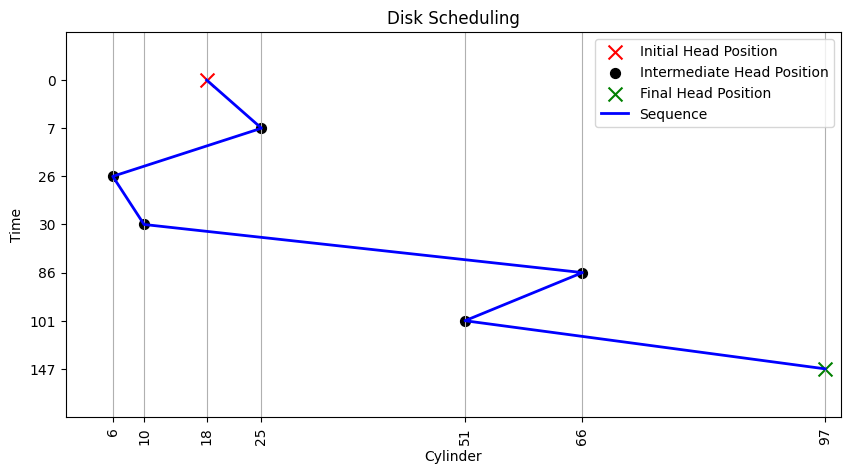

Total head movement: 147
Waiting times (request, time):
[(25, 7.0), (6, 22.0), (10, 18.0), (66, 60.0), (51, 60.0), (97, 80.0)]


In [17]:
sstf_sequence = SSTF(initial_head_position, max_cylinder).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(sstf_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(sstf_sequence)}')
print('Waiting times (request, time):')
print(calc_waiting_times(sstf_sequence, sequence_times, max_cylinder))

FCFS

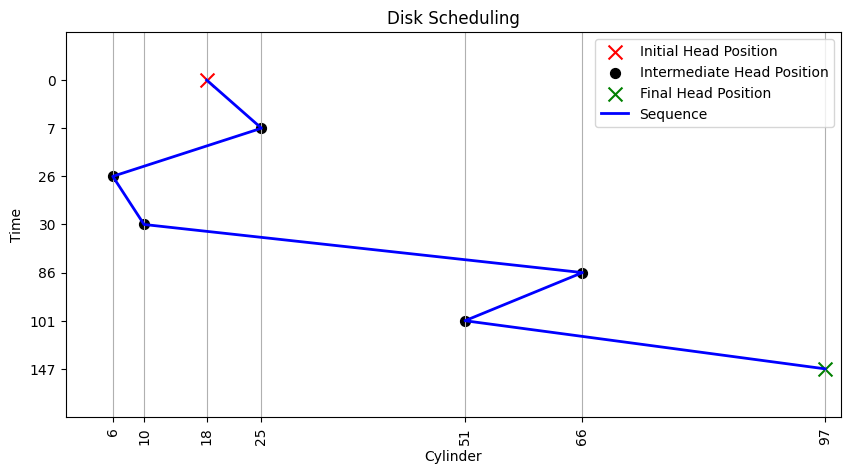

Total head movement: 147
Waiting times (request, time):
[(25, 7.0), (6, 22.0), (10, 18.0), (66, 60.0), (51, 60.0), (97, 80.0)]


In [18]:
fcfs_sequence = FCFS(initial_head_position, max_cylinder).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(fcfs_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(fcfs_sequence)}')
print('Waiting times (request, time):')
print(calc_waiting_times(fcfs_sequence, sequence_times, max_cylinder))

C-LOOK

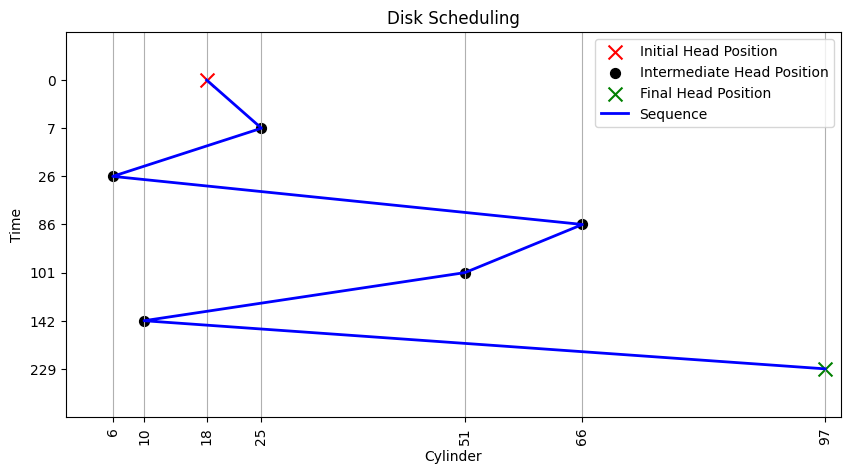

Total head movement: 229
Waiting times (request, time):
[(25, 7.0), (6, 22.0), (66, 74.0), (51, 75.0), (10, 101.0), (97, 162.0)]


In [19]:
c_look_sequence = C_LOOK(initial_head_position, max_cylinder, direction).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(c_look_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(c_look_sequence)}')
print('Waiting times (request, time):')
print(calc_waiting_times(c_look_sequence, sequence_times, max_cylinder))

SCAN

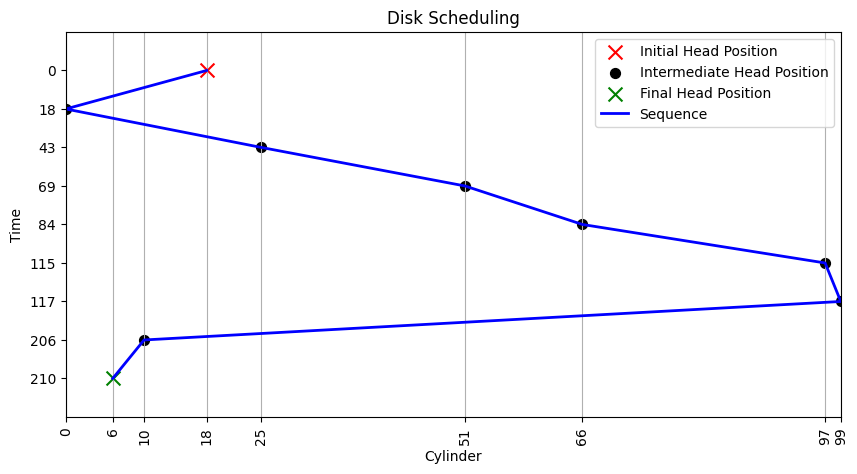

Total head movement: 210
Waiting times (request, time):
[(25, 43.0), (51, 65.0), (66, 72.0), (97, 89.0), (10, 165.0), (6, 143.0)]


In [20]:
scan_sequence = SCAN(initial_head_position, max_cylinder, direction).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(scan_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(scan_sequence)}')
print('Waiting times (request, time):')
print(calc_waiting_times(scan_sequence, sequence_times, max_cylinder))

E22)

In [21]:
sequence = [18, 70, 7, 110, 6, 10, 0, 101, 5]
max_cylinder = 119
initial_head_position = 58
direction = 'left'

LOOK

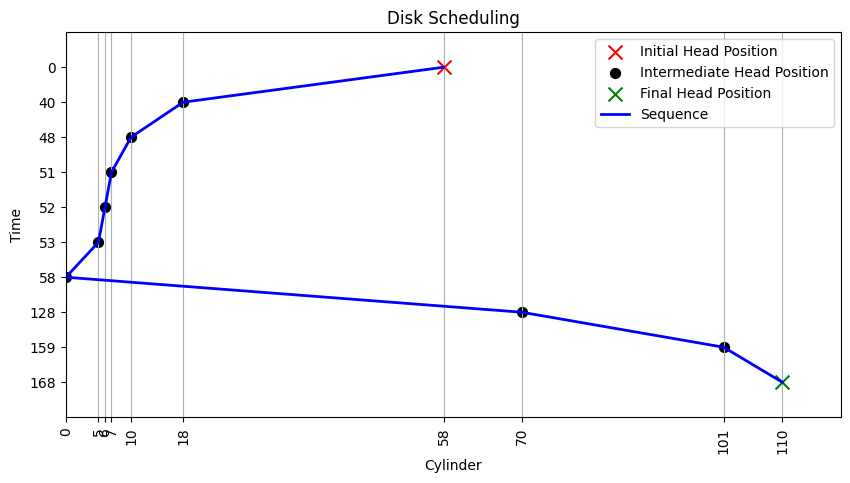

Total head movement: 168
Waiting times (request, time):
[(18, 40), (10, 48), (7, 51), (6, 52), (5, 53), (0, 58), (70, 128), (101, 159), (110, 168)]


In [22]:
look_sequence = LOOK(initial_head_position, max_cylinder, direction).process_sequence(sequence)

plot_sequence(look_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(look_sequence)}')
print('Waiting times (request, time):')
print(calc_cum_seek_time(look_sequence))

SSTF

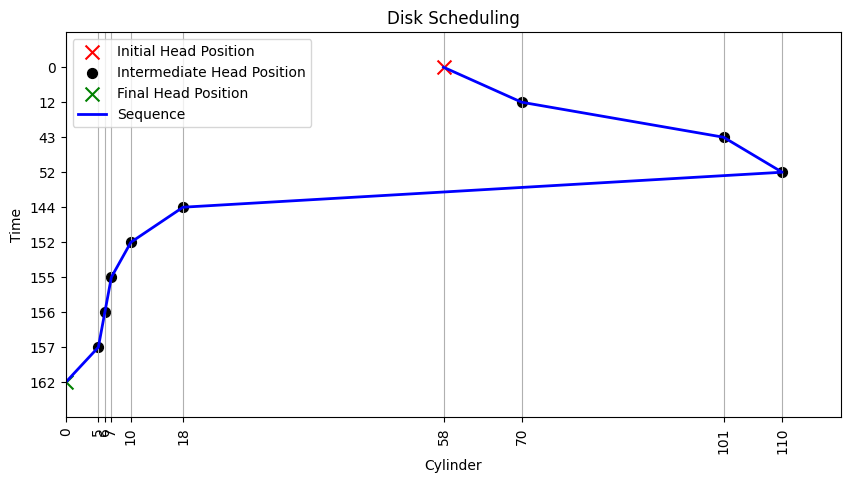

Total head movement: 162
Waiting times (request, time):
[(70, 12), (101, 43), (110, 52), (18, 144), (10, 152), (7, 155), (6, 156), (5, 157), (0, 162)]


In [23]:
sstf_sequence = SSTF(initial_head_position, max_cylinder).process_sequence(sequence)

plot_sequence(sstf_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(sstf_sequence)}')
print('Waiting times (request, time):')
print(calc_cum_seek_time(sstf_sequence))

E31)

In [24]:
sequence_cylinders = [50, 3, 30, 20, 45, 11]
sequence_times = [0, 2, 12, 13, 31, 37]
initial_head_position = 0
max_cylinder = 59
direction = 'right'

SSTF

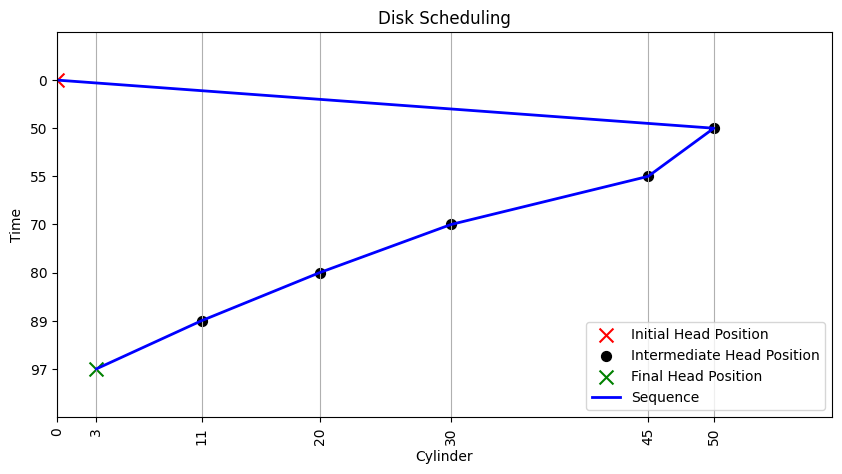

Total head movement: 97
Waiting times (request, time):
[(50, 50.0), (45, 53.0), (30, 58.0), (20, 67.0), (11, 58.0), (3, 60.0)]


In [25]:
sstf_sequence = SSTF(initial_head_position, max_cylinder).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(sstf_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(sstf_sequence)}')
print(f'Waiting times (request, time):')
print(calc_waiting_times(sstf_sequence, sequence_times, max_cylinder))

FCFS

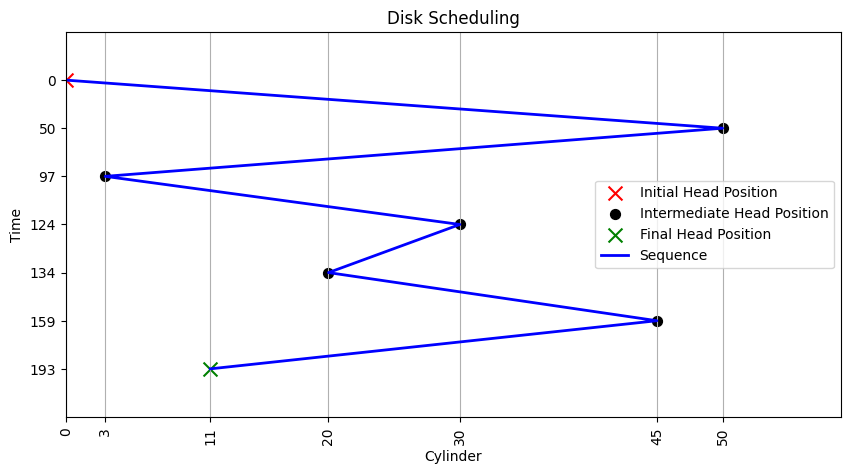

Total head movement: 193
Waiting times (request, time):
[(50, 50.0), (3, 95.0), (30, 112.0), (20, 121.0), (45, 128.0), (11, 156.0)]


In [26]:
fcfs_sequence = FCFS(initial_head_position, max_cylinder).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(fcfs_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(fcfs_sequence)}')
print(f'Waiting times (request, time):')
print(calc_waiting_times(fcfs_sequence, sequence_times, max_cylinder))

LOOK

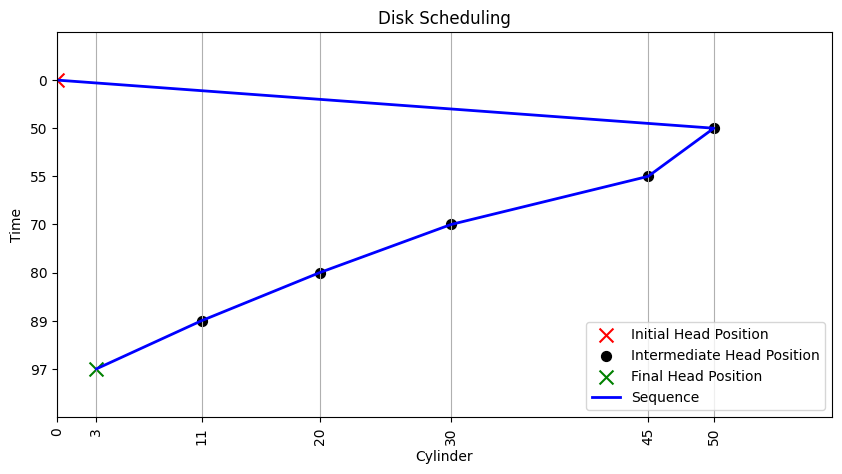

Total head movement: 97
Waiting times (request, time):
[(50, 50.0), (45, 53.0), (30, 58.0), (20, 67.0), (11, 58.0), (3, 60.0)]


In [27]:
look_sequence = LOOK(initial_head_position, max_cylinder, direction).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(look_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(look_sequence)}')
print(f'Waiting times (request, time):')
print(calc_waiting_times(look_sequence, sequence_times, max_cylinder))

LOOK 3 cylinders per ms

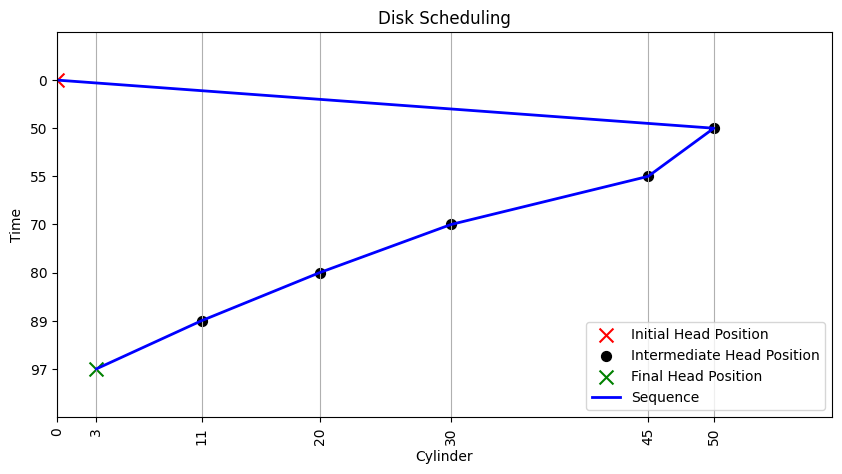

Total head movement: 97
Waiting times (request, time):
[(50, 16.666666666666668), (45, 17.666666666666668), (30, 19.333333333333332), (20, 22.333333333333332), (11, 19.333333333333332), (3, 20.0)]


In [28]:
look_sequence = LOOK(initial_head_position, max_cylinder, direction).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(look_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(look_sequence)}')
print(f'Waiting times (request, time):')
print(calc_waiting_times(look_sequence, sequence_times, max_cylinder, 3))

C-LOOK 3 cylinders per ms

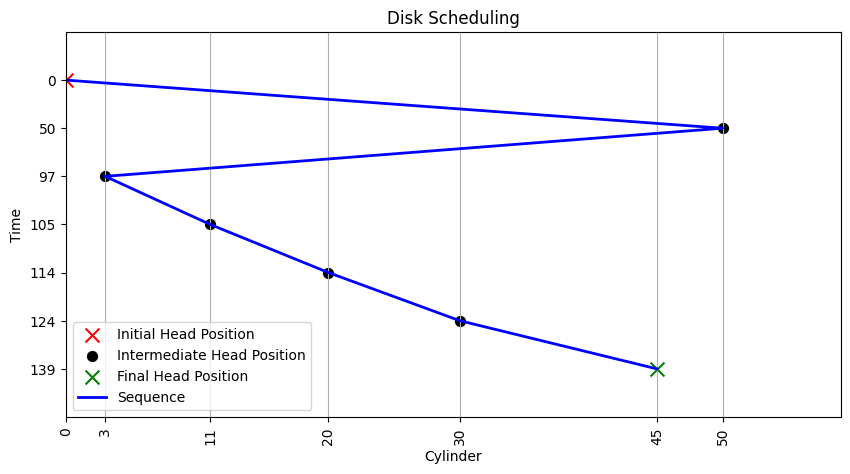

Total head movement: 139
Waiting times (request, time):
[(50, 16.666666666666668), (3, 31.666666666666668), (11, 31.0), (20, 33.666666666666664), (30, 31.0), (45, 34.0)]


In [29]:
c_look_sequence = C_LOOK(initial_head_position, max_cylinder, direction).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(c_look_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(c_look_sequence)}')
print(f'Waiting times (request, time):')
print(calc_waiting_times(c_look_sequence, sequence_times, max_cylinder, 3))

E37)

In [30]:
sequence_cylinders = [33, 66, 99, 22, 11, 55]
sequence_times = [0, 10, 30, 50, 70, 73]
initial_head_position = 0
max_cylinder = 99
direction = 'right'

SSTF

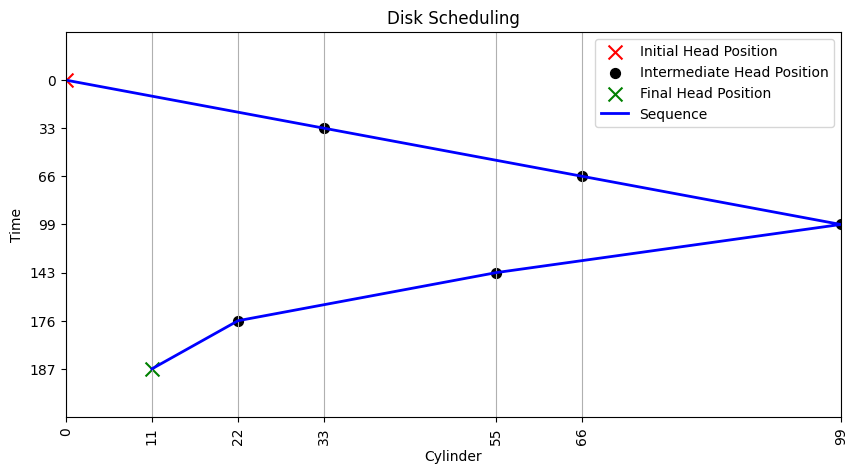

Total head movement: 187
Mean waiting time: 78.5


In [31]:
sstf_sequence = SSTF(initial_head_position, max_cylinder).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(sstf_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(sstf_sequence)}')
print(f'Mean waiting time: {calc_mean_waiting_time(sstf_sequence, sequence_times)}')

FCFS

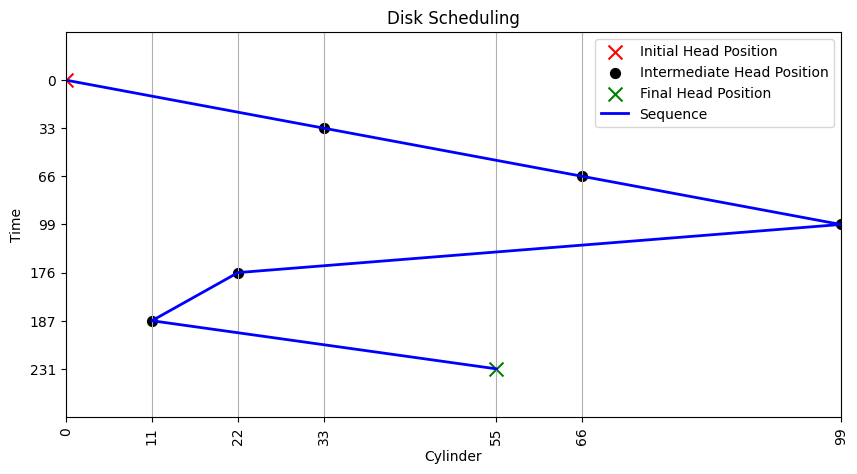

Total head movement: 231
Mean waiting time: 93.16666666666667


In [32]:
fcfs_sequence = FCFS(initial_head_position, max_cylinder).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(fcfs_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(fcfs_sequence)}')
print(f'Mean waiting time: {calc_mean_waiting_time(fcfs_sequence, sequence_times)}')

SCAN

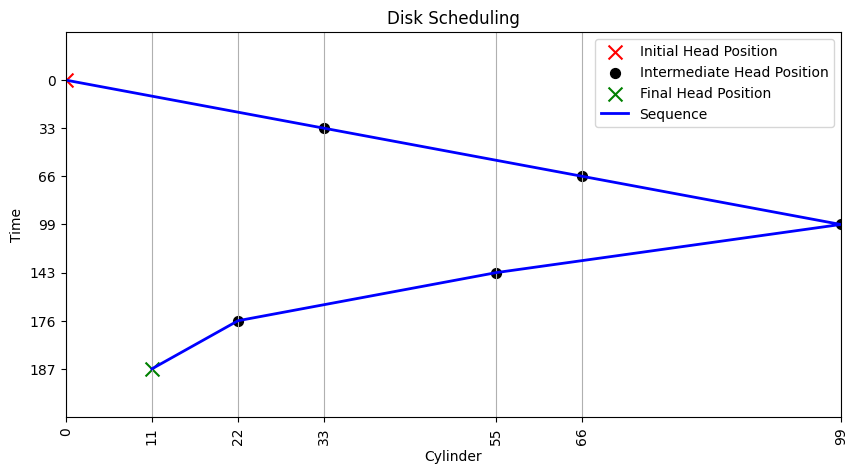

Total head movement: 187
Mean waiting time: 78.5


In [33]:
scan_sequence = SCAN(initial_head_position, max_cylinder, direction).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(scan_sequence, max_cylinder)

print(f'Total head movement: {calc_total_head_movement(scan_sequence)}')
print(f'Mean waiting time: {calc_mean_waiting_time(scan_sequence, sequence_times)}')

E40)

In [34]:
sequence_cylinders = [23, 16, 79, 72, 31, 25]
sequence_times = [0, 20, 30, 70, 71, 73]
initial_head_position = 0
max_cylinder = 79
direction = 'right'

SSTF

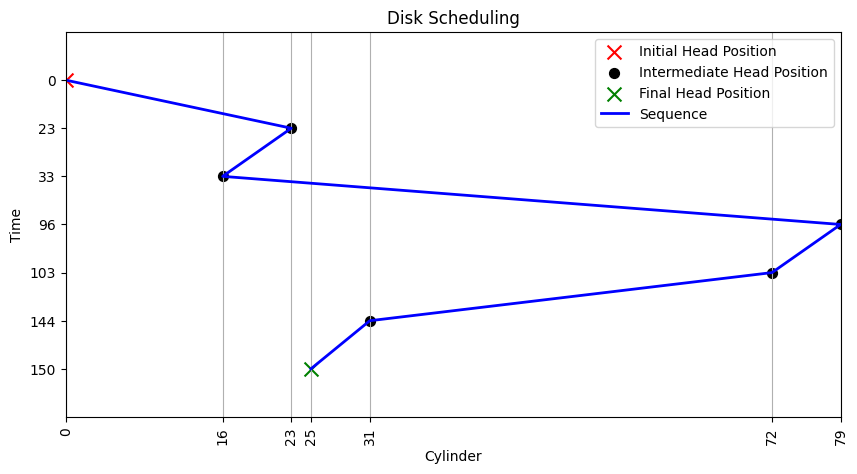

Total head movement: 147
Mean waiting time: 47.5


In [35]:
sstf_sequence = SSTF(initial_head_position, max_cylinder).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(sstf_sequence, max_cylinder, service_time=3)

print(f'Total head movement: {calc_total_head_movement(sstf_sequence)}')
print(f'Mean waiting time: {calc_mean_waiting_time(sstf_sequence, sequence_times, service_time=3)}')

SCAN

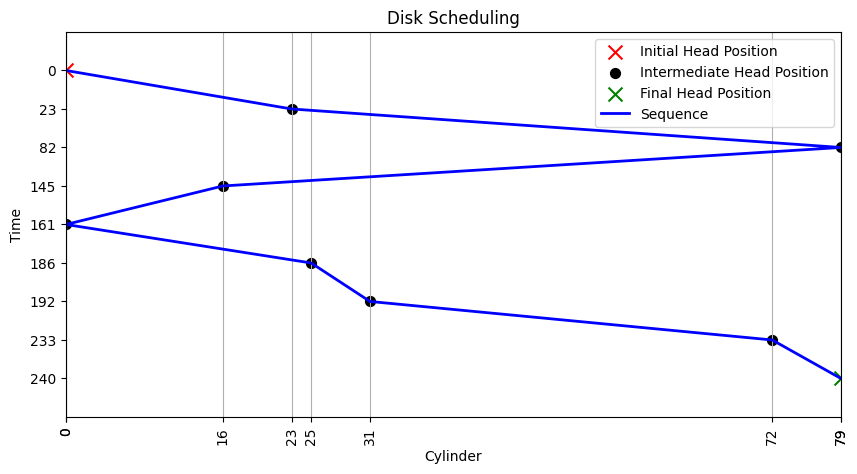

Total head movement: 237


IndexError: list index out of range

In [36]:
scan_sequence = SCAN(initial_head_position, max_cylinder, direction).process_sequence(sequence_cylinders, sequence_times)

plot_sequence(scan_sequence, max_cylinder, service_time=3)

print(f'Total head movement: {calc_total_head_movement(scan_sequence)}')
print(f'Mean waiting time: {calc_mean_waiting_time(scan_sequence, sequence_times, service_time=3)}')